In [1]:
import numpy as np
import math
import random
import warnings
from scipy.integrate import quad
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from scipy.fft import fft, ifft
import scipy.interpolate

import matplotlib as mpl
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 7

In [49]:
state_change_matrix = np.array([
    [1,0,0,0],  # 1.  New F grown
    [0,1,0,0],  # 2.  New H grown
    [0,0,1,0],  # 3.  New S grown
    [0,0,0,1],  # 4.  New M grown
    [-1,0,0,0], # 5.  Existing F pruned
    [0,-1,0,0], # 6.  Existing H pruned
    [0,0,-1,0], # 7.  Existing S pruned
    [0,0,0,-1], # 8.  Existing M pruned
    [1,-1,0,0], # 9.  H transitions to F
    [1,0,-1,0], # 10. S transitions to F
    [1,0,0,-1], # 11. M transitions to F
    [-1,1,0,0], # 12. F transitions to H
    [-1,0,1,0], # 13. F transitions to S
    [-1,0,0,1], # 14. F transitions to M
    [0,1,-1,0], # 15. S transitions to H
    [0,1,0,-1], # 16. M transitions to H
    [0,1,0,-1], # 17. H transitions to S
    [0,0,1,-1], # 18. M transitions to S
    [0,-1,0,1], # 19. H trantisions to M
    [0,0,-1,1]  # 20. S transitions to M
])
state_change_matrix.shape

(20, 4)

In [88]:
def boxcar_smooth(data, window_size):
  if window_size <= 0:
    raise ValueError("Window size must be positive")
  kernel = np.ones(window_size) / window_size
  smoothed_data = np.convolve(data, kernel, mode='same')
  return smoothed_data

def find_closest_timestamp(arr, t):
    ind = np.nanargmin(np.abs(arr - t))
    approx_t = arr[ind]
    return ind, approx_t

In [89]:
x_data = np.array([0, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4])
y_data = np.array([10, 20, 25, 40, 10, 5, 10, 5, 10])
# estradiol_level = np.interp(np.linspace(0,4,100)*24, x_data*24, y_data)
spline_interp = scipy.interpolate.CubicSpline(x_data*24, y_data, bc_type='periodic')
estradiol_level_spline = spline_interp(np.arange(0,96.25,0.25))

# environmental function
def estradiol_lvl(t):
    # `t` must be aligned so that it always begins at the start
    # of diestrus stage.

    # Mod so that any number of hours falls into the 0 to 96 hour range
    t = t%(4*24)
    search_range = np.arange(0,96.25,0.25)
    cycle_ind, _ = find_closest_timestamp(search_range, t)

    # return the current estradiol level
    return estradiol_level_spline[cycle_ind]

In [92]:
symbol_matrix = np.array([
    ['deltaM','gammaM2F','gammaM2H','gammaM2S','lambdaM'],
    ['deltaS','gammaS2F','gammaS2H','lambdaS','gammaS2M'],
    ['deltaH','gammaH2F','lambdaH','gammaH2S','gammaH2M'],
    ['deltaF','lambdaF','gammaF2H','gammaF2S','gammaF2M'],
    ['0','betaF','betaH','betaS','betaM']
])

# Load transition probability matrices
DtoP = np.load('DtoP_transition_matrix.npy')
PtoE = np.load('PtoE_transition_matrix.npy')
EtoM = np.load('EtoM_transition_matrix.npy')
MtoD = np.load('MtoD_transition_matrix.npy')

mats = [DtoP, PtoE, EtoM, MtoD]

# Make a transition matrix that ciruclarly interpolates over the four timepoints of
# transition probabilities so that any timepoint along the cycle has a ~unique
# transition matrix.
transition_dict = {}
for i in range(5): # from
    for j in range(5): # to

        # Get the values across stages
        transvals_across_stages = [mat[i, j] for mat in mats]

        # Interpolate to bins
        spline_interp = scipy.interpolate.CubicSpline(
            np.arange(5)*24,
            np.append(transvals_across_stages, transvals_across_stages[0]),
            bc_type="periodic"
        )
        transvals_at_bins = spline_interp(np.arange(0,96.25,0.25))

        # add to dict
        transition_dict[symbol_matrix[i,j]] = transvals_at_bins

In [ ]:
# Given an estradiol level, can you decode the current transition
# probabilities, or is it ambigious?

In [95]:
# Homogeneous Poisson Process (hpp) inter-event time sampler
def hpp(intentemp):
    total_intensity = sum(intentemp)
    # Avoid division by zero (should be handled by caller)
    return - (1 / total_intensity) * math.log(1 - random.random())

# Nonhomogeneous Poisson Process (nhpp) inter-event time sampler using inverse transform
def nhpp(tottime, pops, inten, timeleft):
    Y = random.random()
    def f(X):
        # Integrate sum of intensities from 0 to X
        integral, _ = quad(lambda x: sum(inten(tottime + x, pops)), 0, X, limit=200)
        return 1 - math.exp(-integral) - Y
    try:
        sol = root_scalar(f, bracket=[0, timeleft], method='bisect', xtol=1e-5)
        return sol.root
    except ValueError:
        # In case no root is found, return a value greater than timeleft
        return timeleft + 1

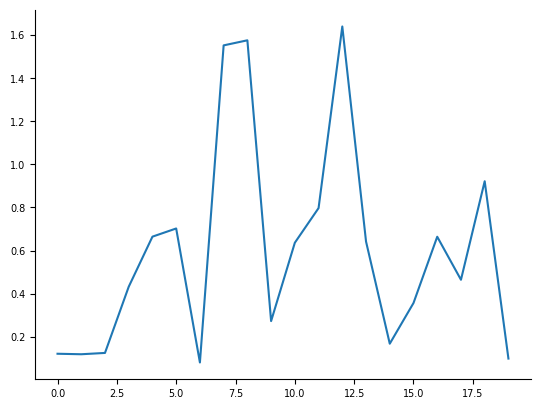

In [96]:
def inten(t, pops):
    # Intensity function and demographic functions combined into single func
    # Should return the values for birth*population, etc. as numbers not as rates

    # Current populations
    F, H, S, M = pops

    # Get the current estradiol level
    # e2_lvl = estradiol_lvl(t) # in pg/mL

    # Find position in estrous cycle and use the appropriate transition
    # values for that point between stages
    tind, _ = find_closest_timestamp(np.arange(0,96.25,0.25), t)

    # Given a cycle position, get the transition probabilities
    use_intensities = {}
    for key,val in transition_dict.items():
        use_intensities[key] = val[tind]

    # Ignore lambda values because these represent staibility not
    # a transition between spine classes
    deltaM = use_intensities['deltaM']*M
    gammaM2F = use_intensities['gammaM2F']*M
    gammaM2H = use_intensities['gammaM2H']*M
    gammaM2S = use_intensities['gammaM2S']*M
    # lambdaM = use_intensities['lambdaM']
    deltaS = use_intensities['deltaS']*S
    gammaS2F = use_intensities['gammaS2F']*S
    gammaS2H = use_intensities['gammaS2H']*S
    # lambdaS = use_intensities['lambdaS']
    gammaS2M = use_intensities['gammaS2M']*S
    deltaH = use_intensities['deltaH']*H
    gammaH2F = use_intensities['gammaH2F']*H
    # lambdaH = use_intensities['lambdaH']
    gammaH2S = use_intensities['gammaH2S']*H
    gammaH2M = use_intensities['gammaH2M']*H
    deltaF = use_intensities['deltaF']*F
    # lambdaF = use_intensities['lambdaF']
    gammaF2H = use_intensities['gammaF2H']*F
    gammaF2S = use_intensities['gammaF2S']*F
    gammaF2M = use_intensities['gammaF2M']*F
    betaF = use_intensities['betaF']
    betaH = use_intensities['betaH']
    betaS = use_intensities['betaS']
    betaM = use_intensities['betaM']

    # dFdt = betaF - deltaF*F + gammaH2F*H + gammaS2F*S + gammaM2F*M - F*(gammaF2H + gammaF2S + gammaF2M)
    # dHdt = betaH - deltaH*H + gammaF2H*F + gammaS2H*S + gammaM2H*M - H*(gammaH2F + gammaH2S + gammaH2M)
    # dSdt = betaS - deltaS*S + gammaF2S*F + gammaH2S*H + gammaM2S*M - S*(gammaS2F + gammaS2H + gammaS2M)
    # dMdt = betaM - deltaM*M + gammaF2M*F + gammaH2M*H + gammaS2M*S - M*(gammaM2F + gammaM2H + gammaM2S)

    # the population intensites, lambda(t), of the point process are the expected rate of occurrence
    # of events at a particular time t
    ppintens = np.array([
        betaF,
        betaH,
        betaS,
        betaM,
        deltaF,
        deltaH,
        deltaS,
        deltaM,
        gammaH2F,
        gammaS2F,
        gammaM2F,
        gammaF2H,
        gammaF2S,
        gammaF2M,
        gammaS2H,
        gammaM2H,
        gammaH2S,
        gammaM2S,
        gammaH2M,
        gammaS2M
    ])

    return ppintens

intenpops = inten(0, [3,4,3,3])
plt.plot(intenpops)

In [133]:
# Gillespie+ simulation using nonhomogeneous Poisson process sampling
def gillespie_plus(init, times, inten, pproc, nhpp_func):
    if len(times) == 0:
        raise ValueError("No time points provided in 'times'")
    if times[0] != 0:
        raise ValueError("First time point is not 0")
    
    tottime = times[0]
    tinc = len(times)
    pops = np.array(init, dtype=float)
    results = np.zeros((tinc, len(pops)))
    results[0, :] = pops.copy()

    i = 1
    while i < tinc:
        results[i, :] = results[i - 1, :].copy()
        while tottime <= times[i]:
            intentemp = inten(tottime, pops)
            # if all(x == 0 for x in intentemp):
            #     for j in range(i, tinc):
            #         results[j, :] = pops.copy()
            #     warnings.warn("Exiting with all intensities equal to 0")
            #     i = tinc
            #     break
            # elif min(intentemp) < 0:
            #     for j in range(i, tinc):
            #         results[j, :] = np.nan
            #     warnings.warn("Exiting with intensity less than 0")
            #     i = tinc
            #     break
            # if all(x == 0 for x in intentemp) or (np.min(intentemp) < 0):
            #     intentemp[intentemp<=0] = np.nan

            # else:
                # Use the nonhomogeneous inter-event sampler with the remaining time interval
            tau = nhpp_func(tottime, pops, inten, times[-1]-tottime)
            tottime += tau

            # Recalculate intensities for the new time.
            intentemp = inten(tottime, pops)

            # Handle negative intensities (before normalizing by the sum) by shifting the up so the lowest
            # intensity is zero. Once scaled by the sum, they'll still sum to 1.
            if np.nanmin(intentemp) < 0:
                intentemp += - np.nanmin(intentemp)

            probabilities = np.array(intentemp) / np.nansum(intentemp)

            _choice = np.arange(pproc.shape[0])
            _probs = probabilities.flatten()

            # Exclude if the probabilities are negative or == 0
            # _choice = _choice[_probs>0]
            # _probs = _probs[_probs>0]
            # _probs[_probs<0] = 0

            # if len(_choice) == 0:
            #     print(_choice, _probs)

            event_index = np.random.choice(_choice, p=_probs)
            if tottime > times[i]:
                results[i, :] = pops.copy()
                pops = pops + pproc[event_index, :]
                break
            else:
                pops = pops + pproc[event_index, :]
        i += 1

    return np.column_stack((times, results))

In [112]:
probabilities = intenpops / np.sum(intenpops)
np.random.choice(np.arange(state_change_matrix.shape[0]), p=probabilities.flatten())

13

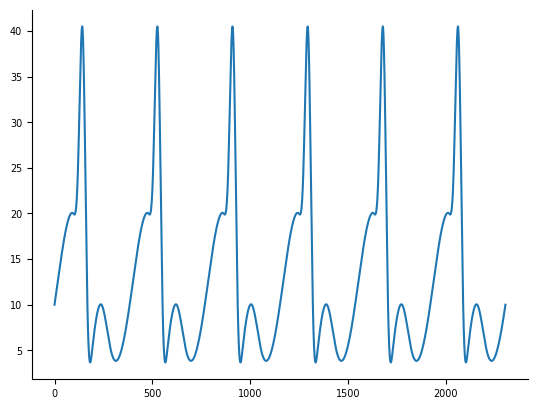

In [113]:
times = np.arange(0,96*6+.25,0.25)
plt.plot([estradiol_lvl(t) for t in times])

In [134]:
# Initial population sizes
init = [8,5,8,7]

# Time grid: from 0 to 20 in steps of 1
# 6 passes through full estrous cycle
times = np.arange(0, 96*6+.25, 0.25)

# Run simulation using gillespie_plus (nonhomogeneous Poisson process sampler)
res_gillespie_plus = gillespie_plus(init, times, inten, state_change_matrix, nhpp)
print("\nResults from gillespie_plus:")
print(res_gillespie_plus)

C:\Users\dmartins\AppData\Local\Temp\ipykernel_20808\3910395613.py:12: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(lambda x: sum(inten(tottime + x, pops)), 0, X, limit=200)



Results from gillespie_plus:
[[ 0.0000e+00  8.0000e+00  5.0000e+00  8.0000e+00  7.0000e+00]
 [ 2.5000e-01  6.0000e+00  5.0000e+00  8.0000e+00  7.0000e+00]
 [ 5.0000e-01  4.0000e+00  6.0000e+00  8.0000e+00  8.0000e+00]
 ...
 [ 5.7550e+02  0.0000e+00  2.0000e+00  4.0000e+00 -4.0000e+00]
 [ 5.7575e+02  0.0000e+00  2.0000e+00  4.0000e+00 -4.0000e+00]
 [ 5.7600e+02  0.0000e+00  2.0000e+00  4.0000e+00 -4.0000e+00]]


In [135]:
res_gillespie_plus.shape

(2305, 5)

In [136]:
res_gillespie_plus

array([[ 0.0000e+00,  8.0000e+00,  5.0000e+00,  8.0000e+00,  7.0000e+00],
       [ 2.5000e-01,  6.0000e+00,  5.0000e+00,  8.0000e+00,  7.0000e+00],
       [ 5.0000e-01,  4.0000e+00,  6.0000e+00,  8.0000e+00,  8.0000e+00],
       ...,
       [ 5.7550e+02,  0.0000e+00,  2.0000e+00,  4.0000e+00, -4.0000e+00],
       [ 5.7575e+02,  0.0000e+00,  2.0000e+00,  4.0000e+00, -4.0000e+00],
       [ 5.7600e+02,  0.0000e+00,  2.0000e+00,  4.0000e+00, -4.0000e+00]])

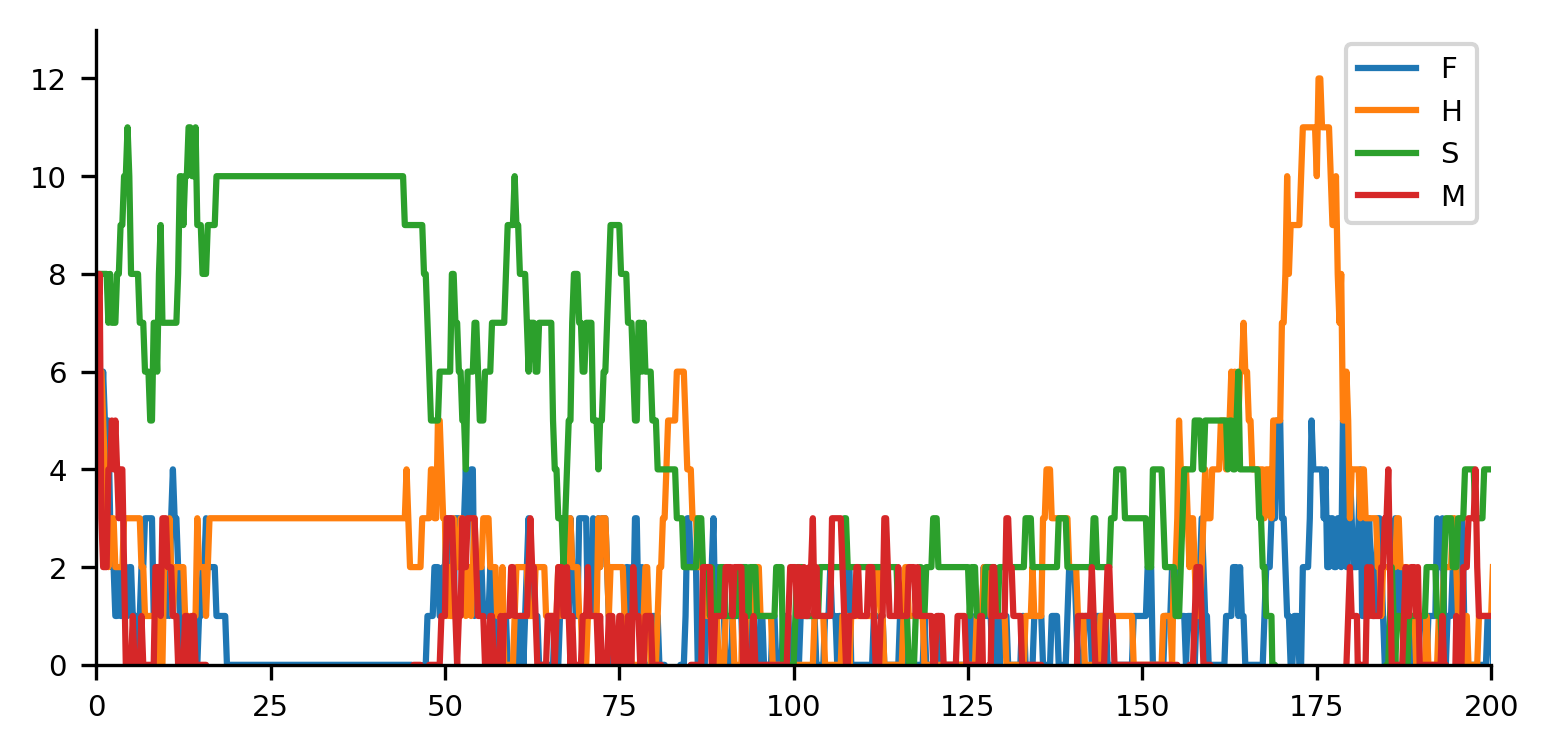

In [139]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(6,2.75))
ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,1], label='F')
ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,2], label='H')
ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,3], label='S')
ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,4], label='M')
ax.set_ylim([0,13])
ax.set_xlim([0,200])
ax.legend()